## This section is for workflow configuration.
This includes:
- Setting the name of this model
- Choosing to skip certain parts
- Choosing whether to reload a past model or not
- Choosing which parts to save or not save
- Choosing a seed for algorithms

In [10]:
from qiskit.utils import algorithm_globals
import os.path
import random

base_model_name = "covertype-effdim-01"  # Name to be used for saving and loading models. Filename friendly string
# NOTE: Filename is not sanitized. Edit at your own risk.
dataset_name = "cover-type"  # Name of the dataset. Used for the log file. String

skip_effective_dimension = False  # If true, skip the effective dimension graphs for quantum and dynamic circuits
# Can save time if you are simply interested in collecting accuracy data.

skip_classical = True  # If true, skip the entire classical model parts.
skip_quantum = True  # If true, skip the entire quantum model parts.
skip_dynamic = False

reload_classical = False  # If true, reload classical model from <base>-classical.keras.
reload_quantum = False  # If true, reload quantum model from <base>-quantum.model.
reload_dynamic = False

save_classical_model = False  # If true, save classical model to <base>-classical.keras.
save_quantum_model = False  # If true, save quantum model to <base>-quantum.model.
save_dynamic_model = False

save_comparison_to_file = True  # If true, save accuracy and runtime stats to <base>-comparison.log.
overwrite_old_log = True  # If true and a log exists where this one would be saved, overwrite it
skip_header = False  # When true, skip the header

play_sound = True  # If true, play a sound when the notebook is finished.
sound_filename = "vine-boom.mp3"  # Filename of sound to play. Must be located in ./assets
# NOTE: Filename is not sanitized. Edit at your own risk.

seed = random.randint(0, 99999)  # Seed for randomization. Integer
algorithm_globals.random_seed = seed
print(seed)

870


## This section is for model configuration.
This includes:
- Number of iterations for training
- Data sampling settings
  - Whether to use a fraction or a set number for the data sample count.
  - Fraction of data subset to sample.
  - Number of data entries to sample 
- Fraction of data to use for training (rest is for testing)
- Maximum size of data batches to be fed into the models.
- Number of features for PCA reduction (used due to memory/qubit constraints.)

In [11]:
iterations = 80  # The set iteration limit for the optimizer. Integer > 0
use_frac = False  # If true, use data_frac as a fraction for sample size. Else use data_count.
data_frac = 0.005  # Fraction of dataset to sample. Decimal [0-1]
data_count = 250  # Number of data entries to sample. Integer [0-number of entries]
train_frac = 0.8  # Fraction of data subset from above to use on training. Decimal [0-1]
batch_size = 250  # Maximum batch size for models. Integer > 0
num_features = 4  # Number of features for model. RFV requires a 2^k number. Integer [0-features]

### This section is for Classical Neural Network specific configuration
This includes:
- Which optimizer to use
- Which loss function to use
- How many neurons the classical neural network uses

In [12]:
classical_optimizer = "adam"
classical_loss = "mae"
classical_inner_neuron_count = num_features * 4

### This section is for Quantum Neural Network specific configuration
This includes:
- Which sampler primitive to use
- Which optimizer to use
- QNN optimization and resilience levels
- QNN shots

In [13]:
import qiskit.algorithms.optimizers
from qiskit.circuit.library import EfficientSU2, ZZFeatureMap, ZFeatureMap
from qiskit_machine_learning.utils.loss_functions import L2Loss, L1Loss, CrossEntropyLoss
from qiskit_machine_learning.circuit.library import RawFeatureVector

sampler_choice = 1  # Flag for which sampler to use. 0 = Default Sampler, 1 = Aer Sampler, 2 = IBM Sampler
use_simulator = True  # If true, IBM Sampler will use a simulator. Otherwise, it will use a real machine.

quantum_optimizer = qiskit.algorithms.optimizers.COBYLA(maxiter=iterations)
# The optimizer object to use for optimizing the model.

feature_map = ZFeatureMap(
    num_features,
    reps=1)
ansatz = EfficientSU2(
    num_qubits=feature_map.num_qubits,
    reps=3,
    flatten=True)
quantum_loss = L2Loss()

opt_level = 1  # The level of optimization for the circuits. [0, 1, 2, 3]
res_level = 1  # The level of resilience hardening for the circuits. [0, 1, 2, 3]
shots = 1024  # Number of repeated circuit executions for QNN. Integer > 0.

## Effective Dimensions settings
These settings are used for all effective dimension measurements, both in quantum and dynamic circuits.

In [14]:
num_eff_dim_tests = 100  # Number of categories to use for ED data collection (think number of trials)
num_eff_dim_data = 25000  # Maximum number of simulated data entries. The ED simulates incrementally larger 'datasets'
num_eff_dim_weight_samples = 10  # Number of random weight arrays to choose from.
num_eff_dim_input_samples = 10  # Number of random input arrays to choose from.
ed_increment = int(num_eff_dim_data / num_eff_dim_tests)
# The increment for the dataset sizes. 
# By default, it is the amount needed to fit num_eff_dim_tests data sizes.
data_size_tests = [n for n in range(ed_increment, num_eff_dim_data + 1, ed_increment)]
# An array of dataset sizes to be given to the effective dimension.
# The values refer to how much data is simulated for the measurement.

### This sections is for Dynamic QNN specific configuration
This includes
- Which optimizer to use
- A description of the dynamic part of the algorithm

In [15]:
dynamic_quantum_optimizer = qiskit.algorithms.optimizers.COBYLA(maxiter=iterations)
dynamic_desc = "Single Dynamic Rotation End Row with No Hadamards"

dynamic_feature_map = ZFeatureMap(
    num_features,
    reps=1)
dynamic_ansatz_blank = EfficientSU2(
    num_qubits=dynamic_feature_map.num_qubits,
    reps=3,
    skip_final_rotation_layer=True,
    flatten=True)
dynamic_loss = L2Loss()

# Data preparation
Here we prepare the dataset we want for use in the models.

In [16]:
from sklearn.utils import Bunch
from sklearn.datasets import fetch_covtype
import pandas as pd
from os.path import normpath

# Put data samples into features and labels from file
data = fetch_covtype(data_home="./data", as_frame=True)
display(data.target)
num_targets = len(data.target.value_counts())

0         5
1         5
2         2
3         2
4         5
         ..
581007    3
581008    3
581009    3
581010    3
581011    3
Name: Cover_Type, Length: 581012, dtype: int32

In [17]:
if use_frac:
    features = data.data.sample(frac=data_frac, random_state=seed)
    labels = data.target.sample(frac=data_frac, random_state=seed).values
else:
    features = data.data.sample(n=data_count, random_state=seed)
    labels = data.target.sample(n=data_count, random_state=seed).values
features = features.values
display(num_targets)
display(features)
display(labels)

7

array([[2750.,  105.,   11., ...,    0.,    0.,    0.],
       [3073.,  333.,   20., ...,    0.,    0.,    0.],
       [3285.,    7.,   12., ...,    0.,    0.,    0.],
       ...,
       [3100.,  119.,   19., ...,    0.,    0.,    0.],
       [2472.,  310.,    7., ...,    0.,    0.,    0.],
       [3293.,   32.,   12., ...,    0.,    0.,    0.]])

array([2, 1, 1, 5, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 3, 3,
       2, 2, 1, 3, 3, 3, 2, 2, 1, 1, 2, 1, 1, 1, 7, 3, 1, 1, 2, 6, 2, 1,
       2, 1, 7, 1, 1, 2, 1, 3, 1, 3, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2,
       1, 2, 1, 1, 2, 5, 2, 2, 5, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2,
       1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 7, 2, 3, 3, 2, 3, 2, 1, 1,
       1, 1, 1, 1, 2, 1, 2, 2, 6, 2, 1, 1, 2, 2, 1, 1, 2, 2, 2, 7, 1, 5,
       2, 2, 3, 2, 2, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 3, 1, 2, 6, 2, 1, 1,
       1, 2, 2, 3, 2, 1, 2, 1, 7, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 3, 2,
       2, 1, 4, 2, 5, 1, 1, 6, 1, 1, 2, 2, 3, 2, 1, 2, 2, 1, 2, 2, 2, 2,
       3, 3, 2, 7, 2, 7, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 5, 2, 2, 1, 1, 2,
       1, 2, 1, 1, 1, 2, 1, 2, 3, 1, 2, 2, 2, 4, 2, 2, 1, 1, 2, 1, 2, 2,
       2, 2, 2, 1, 1, 2, 6, 1])

In [18]:
import numpy as np

# Verify that the right number of features is present
num_sample_targets = len(np.unique(labels))
if num_sample_targets != num_targets: raise ValueError(f"Number of targets in sample ({num_sample_targets}) does not match data's number of targets ({num_targets})!")

In [19]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.decomposition import PCA

# PCA the features, and preprocess them.
features = PCA(n_components=num_features).fit_transform(features)
features = StandardScaler().fit_transform(features)
labels = OrdinalEncoder().fit_transform(labels.reshape(-1, 1))
labels = labels[:, 0]
display(features, labels)
display(features.shape, labels.shape)

array([[-6.65755251e-01,  1.17653539e-01, -4.25335602e-01,
        -6.23560375e-01],
       [-1.26274290e-01, -6.69610671e-01,  5.16939963e-01,
        -2.90438679e-01],
       [-5.18017920e-01, -4.05980485e-01,  1.69983146e+00,
        -4.52488811e-01],
       [-8.90203540e-01,  1.26844250e+00, -2.30564076e-02,
        -9.73385136e-01],
       [ 1.70506829e-01,  9.74101584e-01,  2.56771619e-01,
        -1.47227422e-01],
       [-9.14657677e-01,  9.70386028e-01,  4.09489476e-01,
        -1.62267294e-01],
       [ 1.79644218e+00, -1.23454732e+00, -3.61571788e-01,
         3.44058674e-02],
       [-8.43197298e-01, -3.52486749e-01, -5.87794090e-01,
        -2.89916493e-01],
       [ 5.25519688e-01,  2.44082512e+00, -9.81428250e-01,
         1.52774117e-01],
       [-1.10602717e+00,  1.60371206e-01,  4.85723309e-01,
        -1.18632248e+00],
       [ 1.75553112e+00,  4.52697428e-02, -5.09311148e-01,
         3.04826244e-01],
       [-1.06408416e+00, -5.67542645e-01, -7.49122300e-01,
      

array([1., 0., 0., 4., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0.,
       0., 1., 0., 2., 2., 1., 1., 0., 2., 2., 2., 1., 1., 0., 0., 1., 0.,
       0., 0., 6., 2., 0., 0., 1., 5., 1., 0., 1., 0., 6., 0., 0., 1., 0.,
       2., 0., 2., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1.,
       0., 0., 1., 4., 1., 1., 4., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1.,
       1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 6.,
       1., 2., 2., 1., 2., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 5.,
       1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 6., 0., 4., 1., 1., 2., 1.,
       1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 2., 0., 1., 5., 1., 0.,
       0., 0., 1., 1., 2., 1., 0., 1., 0., 6., 1., 1., 1., 1., 0., 0., 1.,
       1., 0., 1., 1., 2., 1., 1., 0., 3., 1., 4., 0., 0., 5., 0., 0., 1.,
       1., 2., 1., 0., 1., 1., 0., 1., 1., 1., 1., 2., 2., 1., 6., 1., 6.,
       1., 2., 1., 1., 1., 2., 1., 1., 1., 1., 4., 1., 1., 0., 0., 1., 0.,
       1., 0., 0., 0., 1.

(250, 4)

(250,)

In [20]:
from sklearn.model_selection import train_test_split

# Separate into training and testing sets.
train_features, test_features, train_labels, test_labels = train_test_split(
    features,
    labels,
    train_size=train_frac
)
display(train_features.shape, train_labels.shape, test_features.shape, test_labels.shape)

(200, 4)

(200,)

(50, 4)

(50,)

In [21]:
# Verify that the right number of features is present
num_sample_targets = len(np.unique(train_labels))
if num_sample_targets != num_targets: raise ValueError(f"Number of targets in training sample ({num_sample_targets}) does not match data's number of targets ({num_targets})!")

In [22]:
from sklearn.utils import gen_batches

# Create the slices that we can use for batches in training
train_slices = list(gen_batches(train_features.shape[0], batch_size))

In [23]:
from datetime import datetime

# Data logging
if save_comparison_to_file and not skip_header:
    if overwrite_old_log and os.path.isfile(f"./logs/{base_model_name}.log"):
        os.remove(f"./logs/{base_model_name}.log")
    with open(f"./logs/{base_model_name}.log", "a+") as file:
        file.write(f"Model Name:\t{base_model_name}\n")
        file.write(f"Dataset:\t{dataset_name}\n")
        file.write(f"Trial start:\t{datetime.now()}\n")
        file.write(f"Number of features:\t{num_features}\n")
        file.write(f"Number of data entries:\t{features.shape[0]}\n")
        file.write(f"Batch size:\t{batch_size}\n")
        file.write(f"Iterations:\t{iterations}\n")
        file.write(f"Training fraction:\t{train_frac}\n")
        file.write(f"Randomization seed:\t{seed}\n")
        file.write("\n\n")

# Classical Neural Network
We now construct and run the classical neural network locally. This normally doesn't take long at all.

In [24]:
import tensorflow as tf

# Create the Keras neural network model
if not skip_classical:
    if not reload_classical:
        classical_model = tf.keras.Sequential([
            tf.keras.layers.Dense(classical_inner_neuron_count,
                                  activation="relu",
                                  input_shape=[num_features]),
            tf.keras.layers.Dense(units=1)
        ])
    else:
        classical_model = tf.keras.models.load_model(f"./models/{base_model_name}-classical.keras")
    classical_model.compile(optimizer=classical_optimizer,
                            loss=classical_loss,
                            metrics=["accuracy", "sparse_categorical_accuracy"]
                            )
    classical_model.summary()

In [25]:
# Compile the model and use it
if not skip_classical:
    start = datetime.now()
    classical_model.fit(x=train_features, y=train_labels, batch_size=batch_size, epochs=iterations)
    finish = datetime.now()
    print(f"Model trained at {str(finish)}, for a total time of {str(finish - start)}")
    if save_classical_model:
        classical_model.save(f"./models/{base_model_name}-classical.keras")
    display(classical_model.metrics_names)
    classical_test_result = classical_model.evaluate(x=test_features, y=test_labels)
    classical_train_result = classical_model.evaluate(x=train_features, y=train_labels)
    display(f"Classical Training results: {classical_train_result}")
    display(f"Classical Testing results: {classical_test_result}")

In [26]:
# Data logging

if not skip_classical and save_comparison_to_file:
    with open(f"./logs/{base_model_name}.log", "a") as file:
        file.write(f"Classical Optimizer:\t{classical_optimizer}\n")
        file.write(f"Classical Loss:\t{classical_loss}\n")
        file.write(f"Classical Inner Neuron Count:\t{classical_inner_neuron_count}\n")
        file.write(f"Classical Train Time:\t{str(finish - start)}\n")
        file.write(f"Classical Testing Accuracy:\t{classical_test_result[1]}\n")
        file.write(f"Classical Testing Sparse Categorical Accuracy:\t{classical_test_result[2]}\n")
        file.write(f"Classical Training Accuracy:\t{classical_train_result[1]}\n")
        file.write(f"Classical Training Sparse Categorical Accuracy:\t{classical_train_result[2]}\n")
        file.write(f"\n\n")

# Quantum Neural Network
We construct a quantum neural network that can be ran locally or on an IBM simulator/quantum computer.

In [27]:
from qiskit import QuantumCircuit

# Construct the circuit
if not skip_quantum:
    #feature_map = RawFeatureVector(num_features) # Note: RFV requires num_features = 2^k. Also known to break.

    circuit = QuantumCircuit(feature_map.num_qubits)
    circuit.compose(feature_map, inplace=True)
    circuit.compose(ansatz, inplace=True)

    #ansatz.decompose().draw(output="mpl")
    display(circuit.draw(output="mpl"))

In [28]:
# Define the interpreting function for the model
if not skip_quantum:
    def interpret(x):
        return x % num_targets

In [29]:
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_ibm_runtime import QiskitRuntimeService, Options
import qiskit.primitives
import qiskit_aer.primitives
import qiskit_ibm_runtime.sampler
from qiskit_ibm_runtime import Session

# Configuring the Sampler primitive object
if not skip_quantum:
    if sampler_choice == 1:
        custom_sampler = qiskit_aer.primitives.Sampler()
        print("Aer sampler")
    elif sampler_choice == 2:
        service = QiskitRuntimeService(
            channel='ibm_quantum',
            instance='ibm-q-asu/main/pi-deluca'
        )

        options = Options()
        options.execution.shots = shots
        options.optimization_level = opt_level
        options.resilience_level = res_level
        #options.transpilation.skip_transpilation = True

        if use_simulator:
            backend = service.get_backend("simulator_statevector")
        else:
            backend = service.least_busy(min_num_qubits=feature_map.num_qubits,
                                         filters=lambda b: (b.configuration().simulator == True) and (
                                                     b.configuration().conditional == True))

        print(backend.name)
        session = Session(backend=backend, service=service)
        custom_sampler = qiskit_ibm_runtime.Sampler(session=session, options=options)
    else:
        custom_sampler = qiskit.primitives.Sampler()
        print("Default sampler")

    sampler = SamplerQNN(sampler=custom_sampler,
                         circuit=circuit,
                         input_params=feature_map.parameters,
                         weight_params=ansatz.parameters,
                         interpret=interpret,
                         output_shape=num_targets
                         )

In [30]:
from IPython.core.display_functions import clear_output
from matplotlib import pyplot as plt

# Define the graph callback function
if not skip_quantum:
    objective_func_vals = []
    plt.rcParams["figure.figsize"] = (12, 6)
    plt.clf()


    def callback_graph(weights, obj_func_eval):
        clear_output(wait=True)
        objective_func_vals.append(obj_func_eval)
        plt.title("Objective function value against iteration")
        plt.xlabel("Iteration")
        plt.ylabel("Objective function value")
        plt.plot(range(len(objective_func_vals)), objective_func_vals, color=(0.8, 0.5, 0.8))
        plt.show()

In [31]:
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier

# Create classifier
if not skip_quantum:
    if not reload_quantum:
        classifier = NeuralNetworkClassifier(
            sampler,
            one_hot=True,
            optimizer=quantum_optimizer,
            callback=callback_graph,
            warm_start=True,
            loss=quantum_loss,
            initial_point=algorithm_globals.random.random(sampler.num_weights)
        )
    else:
        classifier = NeuralNetworkClassifier.load(f"./models/{base_model_name}-quantum.model")

In [32]:
from qiskit_machine_learning.neural_networks import EffectiveDimension

# Global Effective Dimension Measure
if not skip_quantum and not skip_effective_dimension:
    quantum_global_ed = EffectiveDimension(qnn=sampler, weight_samples=num_eff_dim_weight_samples,
                                           input_samples=num_eff_dim_input_samples)
    quantum_global_ed_measurement = np.array(
        quantum_global_ed.get_effective_dimension(dataset_size=data_size_tests)) / sampler.num_weights
    plt.plot(data_size_tests, quantum_global_ed_measurement, color=(0.8, 0.5, 0.8))
    plt.xlabel("Number of data")
    plt.ylabel("Normalized GLOBAL effective dimension")
    plt.show()

In [33]:
from qiskit_machine_learning.neural_networks import LocalEffectiveDimension

# Untrained Local Effective Dimension
if not skip_quantum and not skip_effective_dimension:
    quantum_local_ed_untrained = LocalEffectiveDimension(qnn=sampler, weight_samples=classifier.initial_point,
                                                         input_samples=train_features)
    quantum_local_ed_untrained_measurement = np.array(
        quantum_local_ed_untrained.get_effective_dimension(dataset_size=data_size_tests)) / sampler.num_weights

In [34]:
# Training
if not skip_quantum:
    plt.clf()
    start = datetime.now()
    display(f"Model started training at {str(start)}")
    for chunk in train_slices:
        print(f"Chunk {chunk}")

        classifier.fit(train_features[chunk], train_labels[chunk])
        if save_quantum_model:
            classifier.save(f"./models/{base_model_name}-quantum.model")

    finish = datetime.now()
    print(f"Model trained at {str(finish)}, for a total time of {str(finish - start)}")

In [35]:
# Evaluation
if not skip_quantum:
    testing_score = classifier.score(test_features, test_labels)
    print(f"Test dataset score:     {testing_score:.6f}")
    training_score = classifier.score(train_features, train_labels)
    print(f"Training dataset score: {training_score:.6f}")
    if sampler_choice == 2:
        session.close()

In [36]:
# Trained Local Effective Dimension and Display
if not skip_quantum and not skip_effective_dimension:
    quantum_local_ed_trained = LocalEffectiveDimension(qnn=sampler, weight_samples=classifier.weights,
                                                       input_samples=train_features)
    quantum_local_ed_trained_measurement = np.array(
        quantum_local_ed_trained.get_effective_dimension(dataset_size=data_size_tests)) / sampler.num_weights
    plt.plot(data_size_tests, quantum_local_ed_trained_measurement, label="Trained Weights", color=(0.8, 0.5, 0.8))
    plt.plot(data_size_tests, quantum_local_ed_untrained_measurement, label="Untrained Weights",
             color=(0.75, 0.625, 0.75))
    plt.xlabel("Number of data")
    plt.ylabel("Normalized LOCAL effective dimension")
    plt.legend()
    plt.show()

In [37]:
# Data logging

if not skip_quantum and save_comparison_to_file:
    with open(f"./logs/{base_model_name}.log", "a") as file:
        if sampler_choice == 1:
            file.write(f"Quantum Execution Location:\tLocal Aer Simulator\n")
        elif sampler_choice == 2:
            file.write(f"Quantum Execution Type:\tRemote IBM {backend.name}\n")
        else:
            file.write(f"Quantum Execution Type:\tLocal Default Simulator\n")

        file.write(f"Quantum Optimizer:\t{type(quantum_optimizer).__name__}\n")
        file.write(f"Quantum Loss Function:\t{type(quantum_loss).__name__}\n")
        file.write(f"Quantum Feature Map:\t{type(feature_map).__name__}\n")
        file.write(f"Quantum Feature Map Number of Reps:\t{feature_map.reps}\n")
        file.write(f"Quantum Ansatz:\t{type(ansatz).__name__}\n")
        file.write(f"Quantum Ansatz Number of Reps:\t{ansatz.reps}\n")
        file.write(f"Quantum Train Time:\t{str(finish - start)}\n")
        file.write(f"Quantum Test Accuracy:\t{testing_score}\n")
        file.write(f"Quantum Train Accuracy:\t{training_score}\n")
        file.write(f"\n\n")

# Dynamic Circuits Quantum Neural Network
We construct a neural network that runs on IBM servers (due to memory limits)

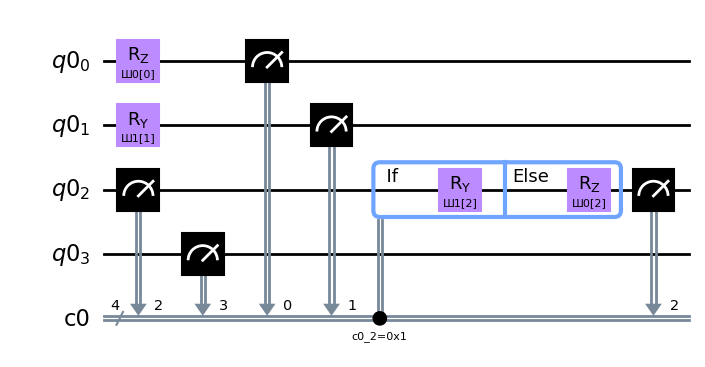

In [38]:
from typing import List
import math
from qiskit.circuit import Parameter
from qiskit import QuantumRegister, ClassicalRegister


# This factory creates a Dynamic Rotation Block quantum circuit of the desired size
# It works by measuring a given quantum register to a classical bit then running
# a conditional block based on that measurement.
# Potential changes include making the conditional blocks input multiple classical bits
# rather than just one.
def DynamicFinalRotationBlockFactory(mask_array: List[int]) -> QuantumCircuit:
    q_reg = QuantumRegister(len(mask_array))
    c_reg = ClassicalRegister(len(mask_array))

    rotation_block_circuit = QuantumCircuit(q_reg, c_reg)
    for i in range(0, len(mask_array), 1):
        param0 = Parameter(name=f"Ш0[{i}]")  # Ш0 (sha 0) represents the rotations if the qubit measure to 0.
        param1 = Parameter(name=f"Ш1[{i}]")  # Ш1 (sha 1) represents the rotations if the qubit measure to 1.
        # The true and false bodies can be replaced by any quantum circuit that uses 1 qubit. Just remember to 
        # adjust your parameters accordingly. Individual gates like RYGate also work.
        true_body = QuantumCircuit(1)
        true_body.ry(param1,0)
        false_body = QuantumCircuit(1)
        false_body.rz(param0,0)

        if mask_array[i] > 1:
            # We measure the circuit as if at the end, seeing if we'd get a 1 or 0
            rotation_block_circuit.measure(q_reg[i], c_reg[i])
    
            # The if-test can see if it is a 1 or 0, and lets the model apply a final rotation
            # to change the results based on its output
            with rotation_block_circuit.if_test((c_reg[i], 1)) as else_:
                #rotation_block_circuit.h(i)
                rotation_block_circuit.compose(other=true_body, qubits=[i], inplace=True)
            with else_:
                #rotation_block_circuit.h(i)
                rotation_block_circuit.compose(other=false_body, qubits=[i], inplace=True)
        elif mask_array[i] == 1:
            rotation_block_circuit.compose(other=true_body, qubits=[i], inplace=True)
        elif mask_array[i] == 0:
            rotation_block_circuit.compose(other=false_body, qubits=[i], inplace=True)
            

        # We then finally measure the results, as otherwise the sampler cries
        rotation_block_circuit.measure(q_reg[i], c_reg[i])

    return rotation_block_circuit


# Example of the structure of a dynamic rotation block.
# It is meant to replace the final rotation block of the ansatz.
DynamicFinalRotationBlockFactory([0,1,2,-1]).draw(output="mpl")

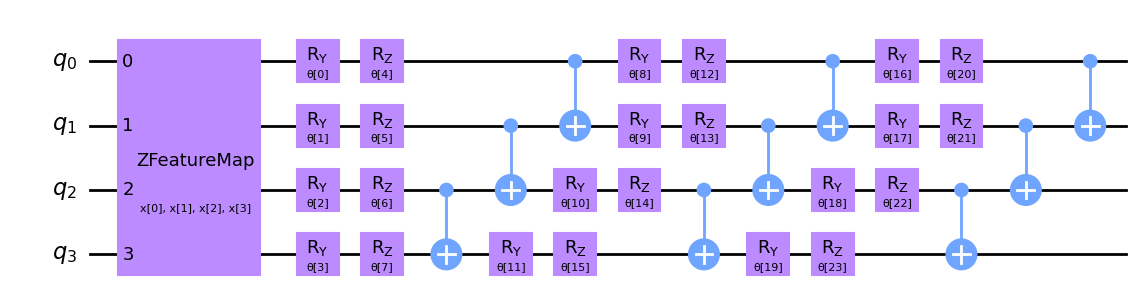

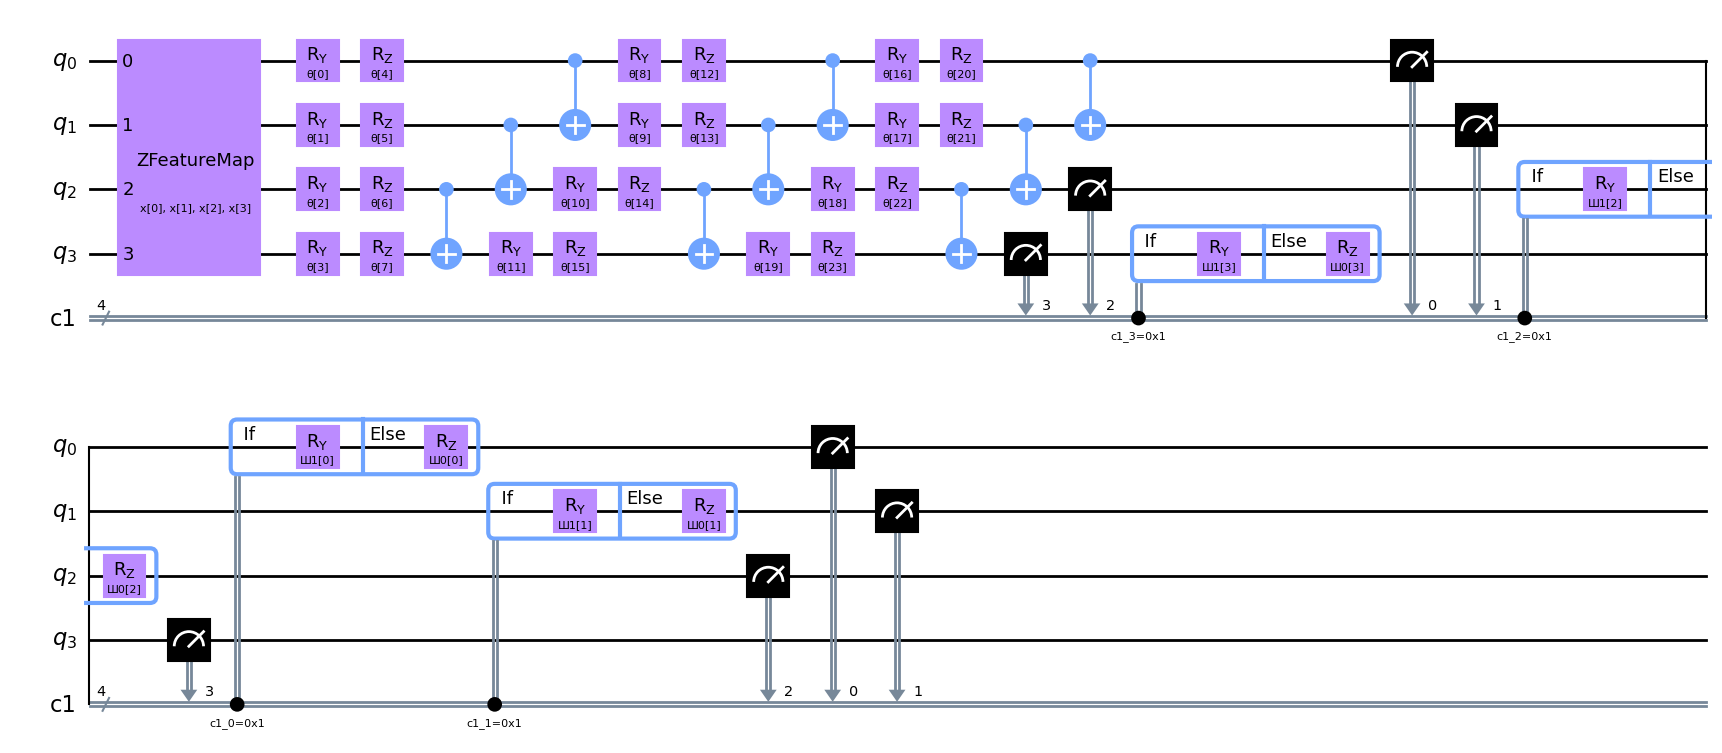

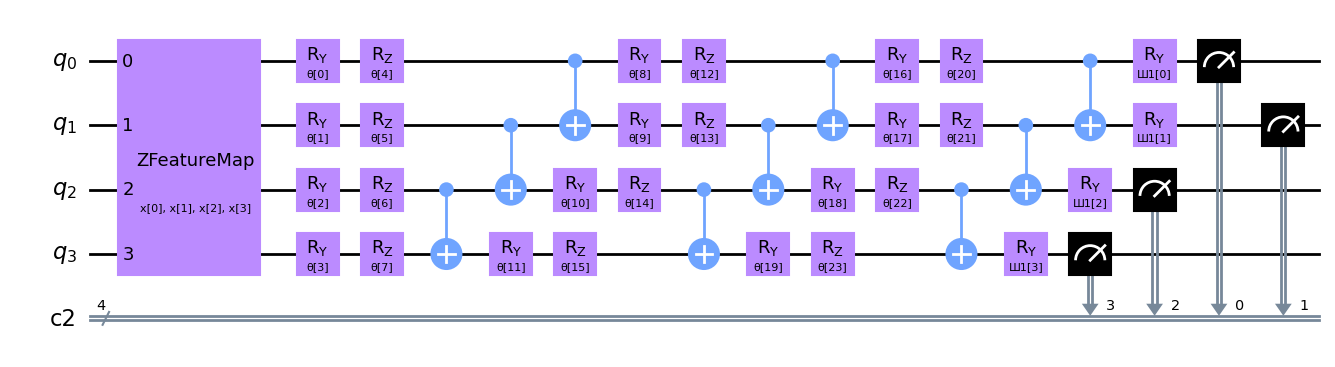

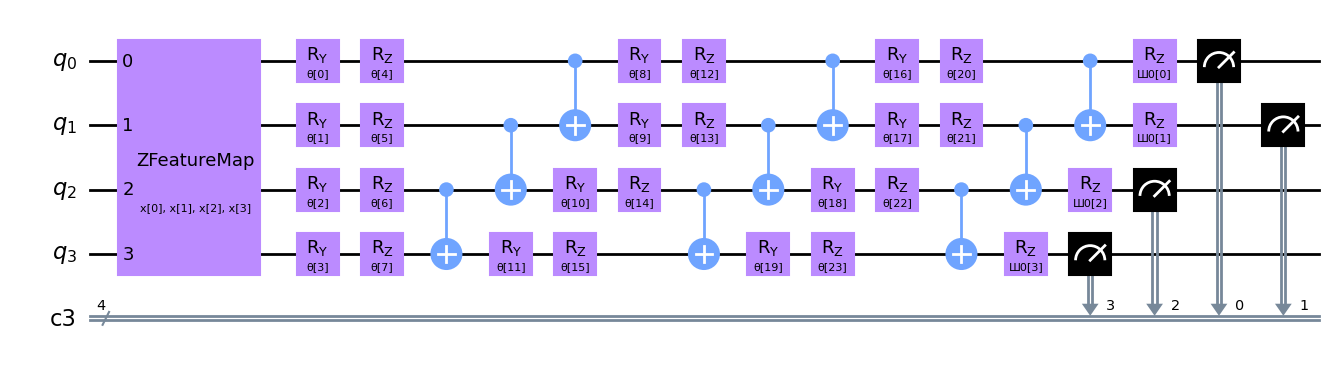

In [39]:
# Construct the circuit
if not skip_dynamic:
    #feature_map = RawFeatureVector(num_features) # Note: RFV requires num_features = 2^k. Also known to break.
    dynamic_circuit = QuantumCircuit(dynamic_feature_map.num_qubits)
    dynamic_circuit.compose(dynamic_feature_map, inplace=True)
    
    dynamic_block_normal = DynamicFinalRotationBlockFactory([2 for x in range(0, dynamic_circuit.num_qubits)])
    dynamic_block_true = DynamicFinalRotationBlockFactory([1 for x in range(0, dynamic_circuit.num_qubits)])
    dynamic_block_false = DynamicFinalRotationBlockFactory([0 for x in range(0, dynamic_circuit.num_qubits)])
    
    dynamic_ansatz_normal = dynamic_ansatz_blank.compose(dynamic_block_normal)
    dynamic_ansatz_true = dynamic_ansatz_blank.compose(dynamic_block_true)
    dynamic_ansatz_false = dynamic_ansatz_blank.compose(dynamic_block_false)

    dynamic_circuit_blank = dynamic_circuit.compose(dynamic_ansatz_blank)
    dynamic_circuit_normal = dynamic_circuit.compose(dynamic_ansatz_normal)
    dynamic_circuit_true = dynamic_circuit.compose(dynamic_ansatz_true)
    dynamic_circuit_false = dynamic_circuit.compose(dynamic_ansatz_false)

    #ansatz.decompose().draw(output="mpl")
    display(dynamic_circuit_blank.draw(output="mpl"))
    display(dynamic_circuit_normal.draw(output="mpl"))
    display(dynamic_circuit_true.draw(output="mpl"))
    display(dynamic_circuit_false.draw(output="mpl"))

In [40]:
# Define the interpreting function for the model
if skip_quantum and not skip_dynamic:
    def interpret(x):
        return x % num_targets

In [41]:
# Configuring the Sampler primitive object
if not skip_dynamic:

    dynamic_custom_sampler = qiskit_aer.primitives.Sampler()

    dynamic_sampler_blank = SamplerQNN(sampler=dynamic_custom_sampler,
                                 circuit=dynamic_circuit_blank,
                                 input_params=dynamic_feature_map.parameters,
                                 weight_params=dynamic_ansatz_blank.parameters,
                                 interpret=interpret,
                                 output_shape=num_targets
                                 )
    dynamic_sampler_normal = SamplerQNN(sampler=dynamic_custom_sampler,
                                 circuit=dynamic_circuit_normal,
                                 input_params=dynamic_feature_map.parameters,
                                 weight_params=dynamic_ansatz_normal.parameters,
                                 interpret=interpret,
                                 output_shape=num_targets
                                 )
    dynamic_sampler_true = SamplerQNN(sampler=dynamic_custom_sampler,
                                 circuit=dynamic_circuit_true,
                                 input_params=dynamic_feature_map.parameters,
                                 weight_params=dynamic_ansatz_true.parameters,
                                 interpret=interpret,
                                 output_shape=num_targets
                                 )
    dynamic_sampler_false = SamplerQNN(sampler=dynamic_custom_sampler,
                                 circuit=dynamic_circuit_false,
                                 input_params=dynamic_feature_map.parameters,
                                 weight_params=dynamic_ansatz_false.parameters,
                                 interpret=interpret,
                                 output_shape=num_targets
                                 )
    

In [42]:
# Define the graph callback function
if not skip_dynamic:
    objective_func_vals = []
    plt.rcParams["figure.figsize"] = (12, 6)
    plt.clf()

if not skip_dynamic:
    def dynamic_callback_graph(weights, obj_func_eval):
        clear_output(wait=True)
        objective_func_vals.append(obj_func_eval)
        plt.title("Objective function value against iteration")
        plt.xlabel("Iteration")
        plt.ylabel("Objective function value")
        plt.plot(range(len(objective_func_vals)), objective_func_vals, color=(0.5, 0.8, 0.8))
        plt.show()

<Figure size 1200x600 with 0 Axes>

In [43]:
# Create classifier
if not skip_dynamic:
    if not reload_dynamic:
        # We get all the weights from the normal training by filtering the results. No need for extra classifiers.
        dynamic_classifier = NeuralNetworkClassifier(
            dynamic_sampler_normal,
            one_hot=True,
            optimizer=dynamic_quantum_optimizer,
            callback=dynamic_callback_graph,
            warm_start=True,
            loss=dynamic_loss,
            initial_point=algorithm_globals.random.random(dynamic_sampler_normal.num_weights)
        )
    else:
        dynamic_classifier = NeuralNetworkClassifier.load(f"./models/{base_model_name}-dynamic.model")

C:\Users\tacos\Documents\school\Fall 2023\CSE486\Capstone-I\venv\lib\site-packages\qiskit_machine_learning\neural_networks\effective_dimension.py:209: RuntimeWarning: invalid value encountered in divide
  gradvectors = np.sqrt(model_outputs) * gradients / model_outputs
C:\Users\tacos\Documents\school\Fall 2023\CSE486\Capstone-I\venv\lib\site-packages\numpy\linalg\linalg.py:2120: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)


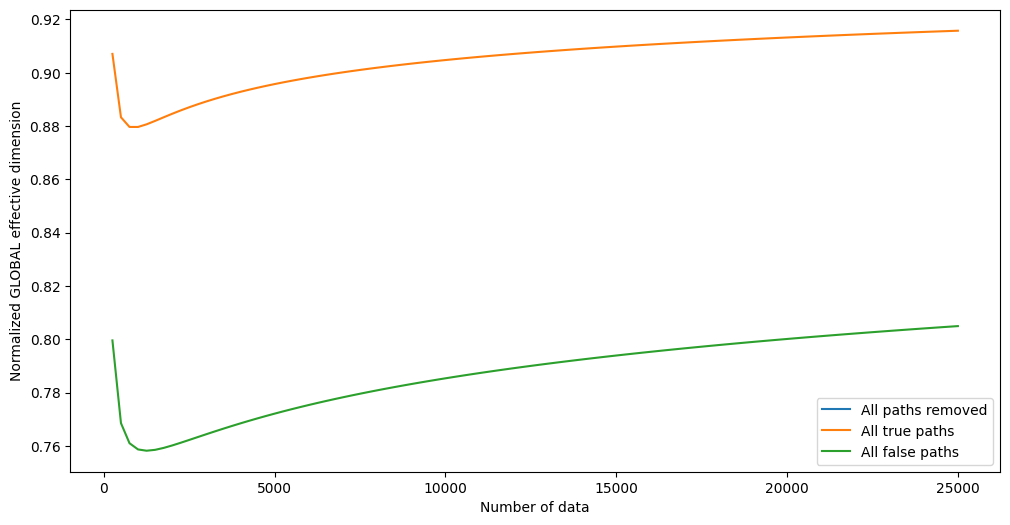

In [44]:
# Global Effective Dimension Measure
if not skip_dynamic and not skip_effective_dimension:
    dynamic_global_ed_blank = EffectiveDimension(qnn=dynamic_sampler_blank, weight_samples=num_eff_dim_weight_samples,
                                           input_samples=num_eff_dim_input_samples)
    dynamic_global_ed_true = EffectiveDimension(qnn=dynamic_sampler_true, weight_samples=num_eff_dim_weight_samples,
                                           input_samples=num_eff_dim_input_samples)
    dynamic_global_ed_false = EffectiveDimension(qnn=dynamic_sampler_false, weight_samples=num_eff_dim_weight_samples,
                                           input_samples=num_eff_dim_input_samples)
    
    
    dynamic_global_ed_measurement_blank = np.array(
        dynamic_global_ed_blank.get_effective_dimension(dataset_size=data_size_tests)) / dynamic_sampler_blank.num_weights
    dynamic_global_ed_measurement_true = np.array(
        dynamic_global_ed_true.get_effective_dimension(dataset_size=data_size_tests)) / dynamic_sampler_true.num_weights
    dynamic_global_ed_measurement_false = np.array(
        dynamic_global_ed_false.get_effective_dimension(dataset_size=data_size_tests)) / dynamic_sampler_false.num_weights
    
    
    plt.plot(data_size_tests, dynamic_global_ed_measurement_blank, label="All paths removed")
    plt.plot(data_size_tests, dynamic_global_ed_measurement_true, label="All true paths")
    plt.plot(data_size_tests, dynamic_global_ed_measurement_false, label="All false paths")
    plt.xlabel("Number of data")
    plt.ylabel("Normalized GLOBAL effective dimension")
    plt.legend()
    plt.show()

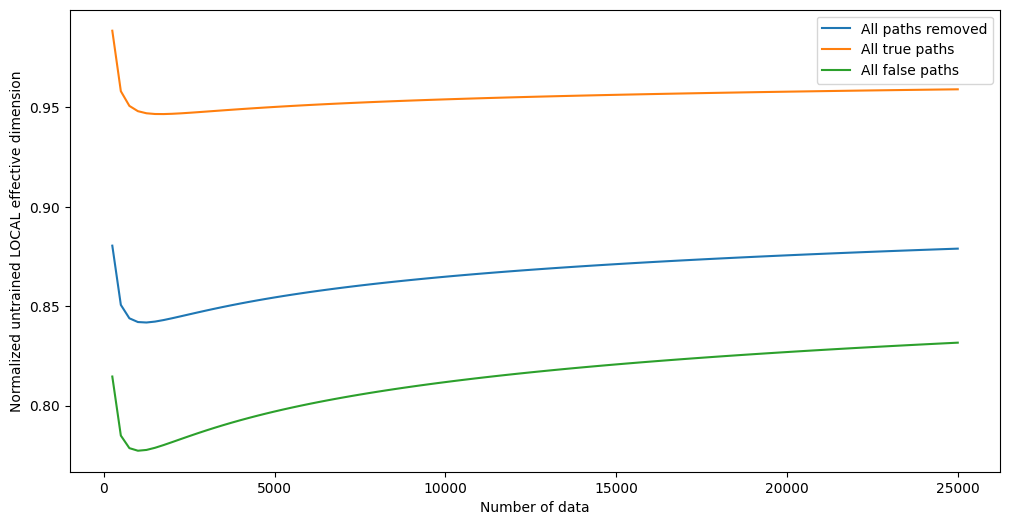

In [45]:
# Untrained Local Effective Dimension
if not skip_dynamic and not skip_effective_dimension:
   
    param_to_initial_weight_dict = {str(param): weight for param, weight in zip(dynamic_sampler_normal.weight_params, dynamic_classifier.initial_point)}
    
    untrained_weights_blank = [param_to_initial_weight_dict[str(param)] for param in dynamic_sampler_blank.weight_params]
    untrained_weights_true = [param_to_initial_weight_dict[str(param)] for param in dynamic_sampler_true.weight_params]
    untrained_weights_false = [param_to_initial_weight_dict[str(param)] for param in dynamic_sampler_false.weight_params]
    
    dynamic_local_ed_untrained_blank = LocalEffectiveDimension(qnn=dynamic_sampler_blank,
                                                         weight_samples=untrained_weights_blank,
                                                         input_samples=train_features)
    dynamic_local_ed_untrained_true = LocalEffectiveDimension(qnn=dynamic_sampler_true,
                                                         weight_samples=untrained_weights_true,
                                                         input_samples=train_features)
    dynamic_local_ed_untrained_false = LocalEffectiveDimension(qnn=dynamic_sampler_false,
                                                         weight_samples=untrained_weights_false,
                                                         input_samples=train_features)
    
    dynamic_local_ed_untrained_measurement_blank = np.array(
        dynamic_local_ed_untrained_blank.get_effective_dimension(dataset_size=data_size_tests)) / dynamic_sampler_blank.num_weights
    dynamic_local_ed_untrained_measurement_true = np.array(
        dynamic_local_ed_untrained_true.get_effective_dimension(dataset_size=data_size_tests)) / dynamic_sampler_true.num_weights
    dynamic_local_ed_untrained_measurement_false = np.array(
        dynamic_local_ed_untrained_false.get_effective_dimension(dataset_size=data_size_tests)) / dynamic_sampler_false.num_weights
    
    plt.plot(data_size_tests, dynamic_local_ed_untrained_measurement_blank, label="All paths removed")
    plt.plot(data_size_tests, dynamic_local_ed_untrained_measurement_true, label="All true paths")
    plt.plot(data_size_tests, dynamic_local_ed_untrained_measurement_false, label="All false paths")
    plt.xlabel("Number of data")
    plt.ylabel("Normalized untrained LOCAL effective dimension")
    plt.legend()
    plt.show()

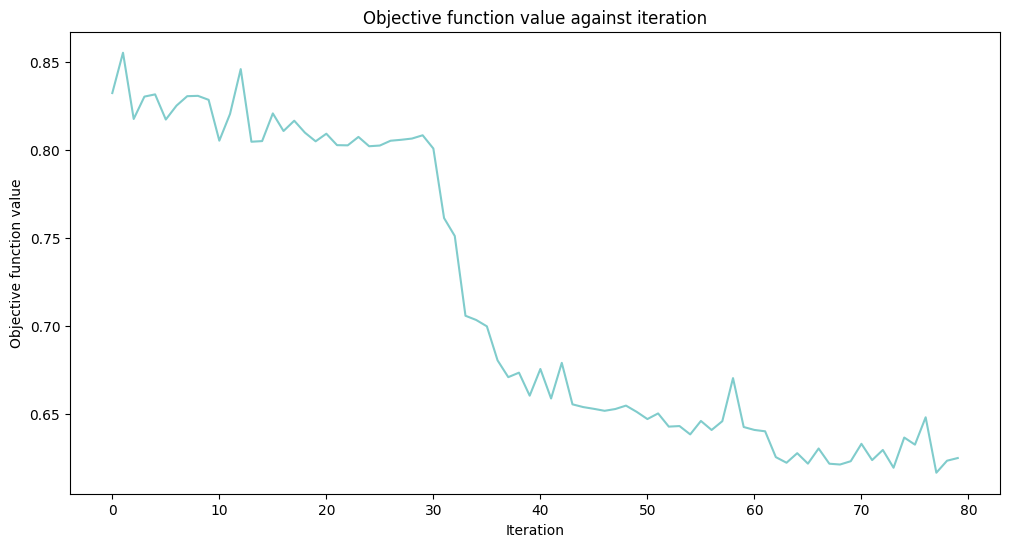

Model trained at 2023-11-14 04:27:50.507261, for a total time of 0:01:55.756294


In [46]:
# Training
if not skip_dynamic:
    plt.clf()
    start = datetime.now()
    display(f"Model started training at {str(start)}")
    for chunk in train_slices:
        print(f"Chunk {chunk}")

        dynamic_classifier.fit(train_features[chunk], train_labels[chunk])
        if save_dynamic_model:
            dynamic_classifier.save(f"./models/{base_model_name}-dynamic.model")

    finish = datetime.now()
    print(f"Model trained at {str(finish)}, for a total time of {str(finish - start)}")

C:\Users\tacos\Documents\school\Fall 2023\CSE486\Capstone-I\venv\lib\site-packages\qiskit_machine_learning\neural_networks\effective_dimension.py:209: RuntimeWarning: invalid value encountered in divide
  gradvectors = np.sqrt(model_outputs) * gradients / model_outputs
C:\Users\tacos\Documents\school\Fall 2023\CSE486\Capstone-I\venv\lib\site-packages\numpy\linalg\linalg.py:2120: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)


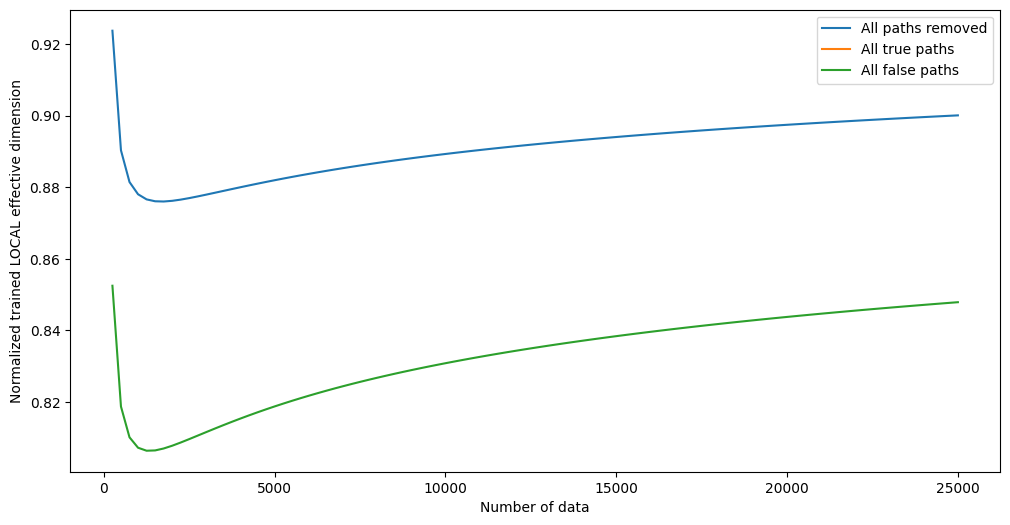

In [47]:
# Trained Local Effective Dimension and Display
if not skip_dynamic and not skip_effective_dimension:
    param_to_weight_dict = {str(param): weight for param, weight in zip(dynamic_sampler_normal.weight_params, dynamic_classifier.weights)}
    
    trained_weights_blank = [param_to_weight_dict[str(param)] for param in dynamic_sampler_blank.weight_params]
    trained_weights_true = [param_to_weight_dict[str(param)] for param in dynamic_sampler_true.weight_params]
    trained_weights_false = [param_to_weight_dict[str(param)] for param in dynamic_sampler_false.weight_params]
    
    dynamic_local_ed_trained_blank = LocalEffectiveDimension(qnn=dynamic_sampler_blank,
                                                         weight_samples=trained_weights_blank,
                                                         input_samples=train_features)
    dynamic_local_ed_trained_true = LocalEffectiveDimension(qnn=dynamic_sampler_true,
                                                         weight_samples=trained_weights_true,
                                                         input_samples=train_features)
    dynamic_local_ed_trained_false = LocalEffectiveDimension(qnn=dynamic_sampler_false,
                                                         weight_samples=trained_weights_false,
                                                         input_samples=train_features)
    
    dynamic_local_ed_trained_measurement_blank = np.array(
        dynamic_local_ed_trained_blank.get_effective_dimension(dataset_size=data_size_tests)) / dynamic_sampler_blank.num_weights
    dynamic_local_ed_trained_measurement_true = np.array(
        dynamic_local_ed_trained_true.get_effective_dimension(dataset_size=data_size_tests)) / dynamic_sampler_true.num_weights
    dynamic_local_ed_trained_measurement_false = np.array(
        dynamic_local_ed_trained_false.get_effective_dimension(dataset_size=data_size_tests)) / dynamic_sampler_false.num_weights
    
    plt.plot(data_size_tests, dynamic_local_ed_trained_measurement_blank, label="All paths removed")
    plt.plot(data_size_tests, dynamic_local_ed_trained_measurement_true, label="All true paths")
    plt.plot(data_size_tests, dynamic_local_ed_trained_measurement_false, label="All false paths")
    plt.xlabel("Number of data")
    plt.ylabel("Normalized trained LOCAL effective dimension")
    plt.legend()
    plt.show()

In [48]:
# Evaluation
if not skip_dynamic:
    testing_score = dynamic_classifier.score(test_features, test_labels)
    print(f"Test dataset score:     {testing_score:.6f}")
    training_score = dynamic_classifier.score(train_features, train_labels)
    print(f"Training dataset score: {training_score:.6f}")

Test dataset score:     0.520000
Training dataset score: 0.465000


In [50]:
# Data logging
if not skip_dynamic and save_comparison_to_file:
    with open(f"./logs/{base_model_name}.log", "a") as file:
        file.write(f"Dynamic Execution Type:\tLocal Aer Simulator\n")
        file.write(f"Dynamic Optimizer:\t{type(dynamic_quantum_optimizer).__name__}\n")
        file.write(f"Dynamic Loss Function:\t{type(dynamic_loss).__name__}\n")
        file.write(f"Dynamic Feature Map:\t{type(dynamic_feature_map).__name__}\n")
        file.write(f"Dynamic Feature Map Number of Reps:\t{dynamic_feature_map.reps}\n")
        file.write(f"Dynamic Ansatz:\t{type(dynamic_ansatz_blank).__name__} + {dynamic_desc}\n")
        file.write(f"Dynamic Ansatz Number of Reps:\t{dynamic_ansatz_blank.reps}\n")
        file.write(f"Dynamic Train Time:\t{str(finish - start)}\n")
        file.write(f"Dynamic Test Accuracy:\t{testing_score}\n")
        file.write(f"Dynamic Train Accuracy:\t{training_score}\n")
        file.write(f"\n\n")

In [51]:
from IPython.display import Audio
import IPython.display

if play_sound:
    # Beep to indicate finished job
    IPython.display.display(Audio(f"./assets/{sound_filename}", autoplay=True))
display(f"Finished at {datetime.now()}")

'Finished at 2023-11-14 04:28:57.683172'